In [1]:
import numpy as np
import gc
from matplotlib import pyplot as plt

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import compute_statistics as cs
import data_loader
import utils
import plotter

%load_ext autoreload
%autoreload 2

2026-02-18 21:28:37.087365: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-18 21:28:37.190234: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-18 21:28:37.190273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-18 21:28:37.203736: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-18 21:28:37.233999: I tensorflow/core/platform/cpu_feature_guar

# Check effect of Anoise being negative

Take muchisimocks mock with SHAMe cosmology (one of new fixed-param LH):

In [2]:
tag_params = '_shame_p0_n1000'
box_size = 1000.0
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib{tag_params}'
idx_mock = 0
fn_fields = f'{dir_mocks}/mock{idx_mock}/bias_fields_eul_deconvolved_{idx_mock}.npy'
bias_terms_eul = np.load(fn_fields)

In [3]:
params_df, param_dict_fixed = data_loader.load_cosmo_params(tag_params)
if params_df is None:
    param_dict = param_dict_fixed
else:
    param_dict = params_df.iloc[0].to_dict()
    param_dict.update(param_dict_fixed)
cosmo = utils.get_cosmo(param_dict)

In [4]:
tag_mock = '_nbar0.00022'
param_dict_forbias = data_loader.load_params_ood('shame', tag_mock)
bias_vector = [param_dict_forbias[name] for name in utils.biasparam_names_ordered]

In [5]:
# dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib_ood/shame'
# subdir_prefix = 'mock'
# tag_mock = '_nbar0.00022'
# box_size = 1000.0
# idx_mock = 0
# fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_mock}/bias_fields_eul_deconvolved_{idx_mock}.npy'
# bias_terms_eul = np.load(fn_fields)

In [6]:
#param_dict = data_loader.load_params_ood('shame', tag_mock)
# cosmo = utils.get_cosmo(param_dict)
# bias_vector = [param_dict[name] for name in utils.biasparam_names_ordered]

In [7]:
n_grid = 128
rng = np.random.default_rng(seed=42)
noise_field_unit = rng.standard_normal((n_grid, n_grid, n_grid))

Deterministic (noiseless) part:

In [ ]:
n_grid_orig = 512
bs = np.concatenate(([1.0], bias_vector))
#tracer_field_ff_det = np.sum([bs[i] * bias_terms_eul[i] for i in range(len(bs))], axis=0) / n_grid_orig**3
tracer_field_ff_det = utils.get_tracer_field(bias_terms_eul, bias_vector, n_grid_orig, 
                                             noise_field=None, A_noise=None)

Define a few Anoise vectors:

In [9]:
As_noise_pos = [1.0, 1.0, 1.0, 1.0, 1.0]
As_noise_neg = [-1.0, -1.0, -1.0, -1.0, -1.0]
As_noise_mix = [1.0, -1.0, 1.0, -1.0, 1.0]
As_noise_mix2 = [-1.0, 1.0, -1.0, 1.0, -1.0]
As_noise_mix3 = [1.0, 1.0, -1.0, -1.0, 1.0]

In [10]:
tracer_field_ff_pos = utils.get_tracer_field(bias_terms_eul, bias_vector, n_grid_norm=n_grid_orig, 
                                                  noise_field=noise_field_unit, A_noise=As_noise_pos)
tracer_field_ff_neg = utils.get_tracer_field(bias_terms_eul, bias_vector, n_grid_norm=n_grid_orig, 
                                                  noise_field=noise_field_unit, A_noise=As_noise_neg)
tracer_field_ff_mix = utils.get_tracer_field(bias_terms_eul, bias_vector, n_grid_norm=n_grid_orig, 
                                                  noise_field=noise_field_unit, A_noise=As_noise_mix)
tracer_field_ff_mix2 = utils.get_tracer_field(bias_terms_eul, bias_vector, n_grid_norm=n_grid_orig, 
                                                  noise_field=noise_field_unit, A_noise=As_noise_mix2)
tracer_field_ff_mix3 = utils.get_tracer_field(bias_terms_eul, bias_vector, n_grid_norm=n_grid_orig, 
                                                  noise_field=noise_field_unit, A_noise=As_noise_mix3)

Compute statistics:

In [11]:
pk_obj_det = cs.compute_pk(tracer_field_ff_det, cosmo, box_size, n_threads=1, fn_stat=None)
pk_obj_pos = cs.compute_pk(tracer_field_ff_pos, cosmo, box_size, n_threads=1, fn_stat=None)
pk_obj_neg = cs.compute_pk(tracer_field_ff_neg, cosmo, box_size, n_threads=1, fn_stat=None)
pk_obj_mix = cs.compute_pk(tracer_field_ff_mix, cosmo, box_size, n_threads=1, fn_stat=None)
pk_obj_mix2 = cs.compute_pk(tracer_field_ff_mix2, cosmo, box_size, n_threads=1, fn_stat=None)
pk_obj_mix3 = cs.compute_pk(tracer_field_ff_mix3, cosmo, box_size, n_threads=1, fn_stat=None)

Computing pk, using n_grid =  128


2026-02-18 21:28:45,293 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:28:46,839 bacco.statistics :  ...done in 1.55 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.999999 (grid1) 0.999999 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.016921 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043216 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000126 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-02-18 21:28:46,842 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:28:46,910 bacco.statistics :  ...done in 0.0685 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00085 (grid1) 1.00085 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013539 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041506 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000125 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-02-18 21:28:46,911 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:28:46,986 bacco.statistics :  ...done in 0.0753 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.999145 (grid1) 0.999145 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014472 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042749 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000129 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-02-18 21:28:46,987 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:28:47,068 bacco.statistics :  ...done in 0.0811 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00041 (grid1) 1.00041 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014093 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042209 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000127 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-02-18 21:28:47,069 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.999588 (grid1) 0.999588 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013801 sec
bacco.power : Counting modes


2026-02-18 21:28:47,151 bacco.statistics :  ...done in 0.0821 s


bacco.power : done counting modes in 0.042017 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000129 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-02-18 21:28:47,152 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0


2026-02-18 21:28:47,231 bacco.statistics :  ...done in 0.0792 s


bacco.power : total mass 0.99939 (grid1) 0.99939 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013703 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042645 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000126 secs
bacco.power : Deallocating arrays


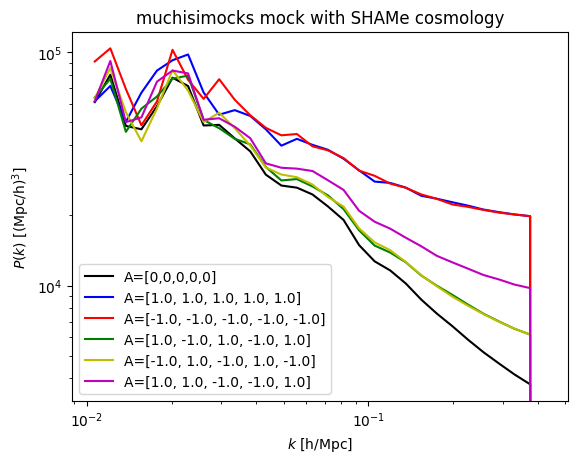

In [12]:
plt.title("muchisimocks mock with SHAMe cosmology")
plt.plot(pk_obj_det['k'], pk_obj_det['pk'], label="A=[0,0,0,0,0]", c='k')
plt.plot(pk_obj_pos['k'], pk_obj_pos['pk'], label=f"A={As_noise_pos}", c='b')
plt.plot(pk_obj_neg['k'], pk_obj_neg['pk'], label=f"A={As_noise_neg}", c='r')
plt.plot(pk_obj_mix['k'], pk_obj_mix['pk'], label=f"A={As_noise_mix}", c='g')
plt.plot(pk_obj_mix2['k'], pk_obj_mix2['pk'], label=f"A={As_noise_mix2}", c='y')
plt.plot(pk_obj_mix3['k'], pk_obj_mix3['pk'], label=f"A={As_noise_mix3}", c='m')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]')
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]')
plt.legend()
plt.show()



Same for bispectrum

In [13]:
box_size = 1000.0
base = cs.setup_bispsec(box_size, n_grid, n_threads=1)


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: none
# Using fftw backend
PolyBin3D setup time: 0.19 s


In [14]:
bspec_det, bk_corr_det = cs.compute_bispectrum(base, tracer_field_ff_det)
bspec_pos, bk_corr_pos = cs.compute_bispectrum(base, tracer_field_ff_pos)
bspec_neg, bk_corr_neg = cs.compute_bispectrum(base, tracer_field_ff_neg)
bspec_mix, bk_corr_mix = cs.compute_bispectrum(base, tracer_field_ff_mix)
bspec_mix2, bk_corr_mix2 = cs.compute_bispectrum(base, tracer_field_ff_mix2)
bspec_mix3, bk_corr_mix3 = cs.compute_bispectrum(base, tracer_field_ff_mix3)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l

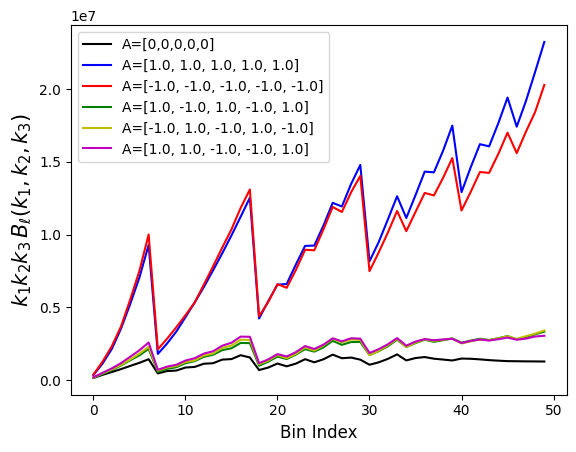

In [15]:
ks = bspec_det.get_ks()
weight = ks.prod(axis=0)
norm = n_grid**3
bk_det = norm**3 * weight * bk_corr_det['b0']
bk_pos = norm**3 * weight * bk_corr_pos['b0']
bk_neg = norm**3 * weight * bk_corr_neg['b0']
bk_mix = norm**3 * weight * bk_corr_mix['b0']
bk_mix2 = norm**3 * weight * bk_corr_mix2['b0']
bk_mix3 = norm**3 * weight * bk_corr_mix3['b0']
plt.plot(bk_det, label="A=[0,0,0,0,0]", c='k')
plt.plot(bk_pos, label=f"A={As_noise_pos}", c='b')
plt.plot(bk_neg, label=f"A={As_noise_neg}", c='r')
plt.plot(bk_mix, label=f"A={As_noise_mix}", c='g')
plt.plot(bk_mix2, label=f"A={As_noise_mix2}", c='y')
plt.plot(bk_mix3, label=f"A={As_noise_mix3}", c='m')
plt.xlabel(r'Bin Index', fontsize=12)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$', fontsize=15)
plt.legend()
plt.show()

The signs of A do matter when we have multiple bias fields! 

# Check additive Gaussian noise model

In [16]:
tag_noise = f'_noise{tag_params}'
dir_noise = f'/scratch/kstoreyf/muchisimocks/data/noise_fields/fields{tag_noise}'
fn_noise = f"{dir_noise}/noise_field_n{idx_mock}.npy"
noise_field_norm = np.load(fn_noise)
print(noise_field_norm.shape)

(128, 128, 128)


In [17]:
norm = n_grid**3
As = [-2.0, -1.0, 1.0, 2.0]
pk_objs = []
bks = []
for A in As:
    tracer_field_ff_add = utils.get_tracer_field(bias_terms_eul, bias_vector, n_grid_orig,
                                                  noise_field=noise_field_norm, A_noise=A, noise_model='additive')
    pk_obj = cs.compute_pk(tracer_field_ff_add, cosmo, box_size, n_threads=1, fn_stat=None)
    pk_objs.append(pk_obj)
    bspec, bk_corr = cs.compute_bispectrum(base, tracer_field_ff_add)
    weight = bspec.get_ks().prod(axis=0)
    bk = norm**3 * weight * bk_corr['b0']
    bks.append(bk)


Computing pk, using n_grid =  128


2026-02-18 21:29:12,137 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:29:12,216 bacco.statistics :  ...done in 0.0789 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00274 (grid1) 1.00274 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013339 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041868 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000134 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
Computing pk, using n_grid =  128


2026-02-18 21:29:15,350 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:29:15,417 bacco.statistics :  ...done in 0.0679 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00137 (grid1) 1.00137 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013509 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041791 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000122 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
Computing pk, using n_grid =  128


2026-02-18 21:29:18,548 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:29:18,619 bacco.statistics :  ...done in 0.0704 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.998631 (grid1) 0.998631 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013616 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041636 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000122 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
Computing pk, using n_grid =  128


2026-02-18 21:29:21,747 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:29:21,817 bacco.statistics :  ...done in 0.0702 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.997263 (grid1) 0.997263 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013455 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041383 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000121 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


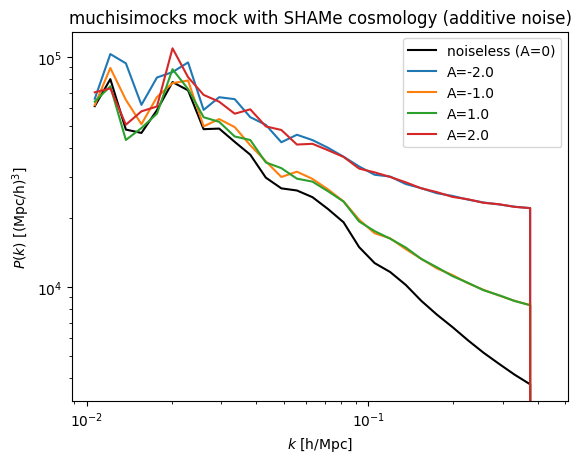

In [18]:
plt.title("muchisimocks mock with SHAMe cosmology (additive noise)")
plt.plot(pk_obj_det['k'], pk_obj_det['pk'], label="noiseless (A=0)", c='k')
for i, A in enumerate(As):
    plt.plot(pk_objs[i]['k'], pk_objs[i]['pk'], label=f"A={A}", c=f'C{i}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]')
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]')
plt.legend()
plt.show()


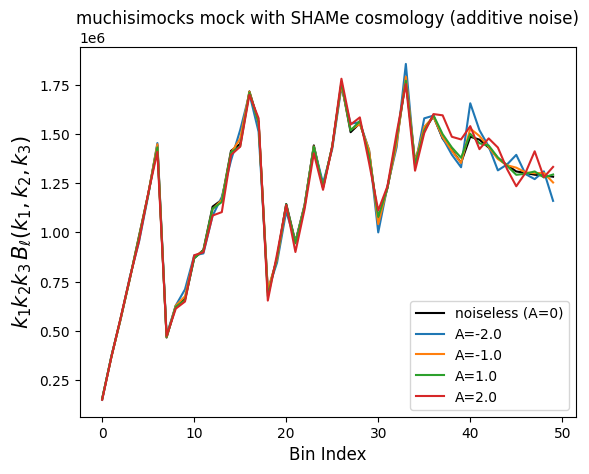

In [19]:
plt.title("muchisimocks mock with SHAMe cosmology (additive noise)")
plt.plot(bk_det, label=f"noiseless (A=0)", c='k')
for i, A in enumerate(As):
    plt.plot(bks[i], label=f"A={A}", c=f'C{i}')
plt.xlabel(r'Bin Index', fontsize=12)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$', fontsize=15)
plt.legend()
plt.show()

# Check effect of Anoise on statistics

In [20]:
tag_mock = '_nbar0.00022'

data_mode_test = 'shame'
tag_data_train = None # this is used for mask
statistics = ['pk', 'bispec']
k_mock, y_mock, y_err_mock = data_loader.load_data_ood(data_mode_test, statistics, tag_mock, tag_data=tag_data_train)

Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data


In [21]:
## Vary A_noise and A2_noise parameters - Compute

# Set parameter ranges for each of the 10 parameters individually
# First 5 are for A_noise[0] through A_noise[4], last 5 are for A2_noise[0] through A2_noise[4]
# Format: [[min, max], [min, max], ...] for each parameter
param_ranges_A = [
    [-3.0, 3.0],   # A_noise[0]
    [-3.0, 3.0],   # A_noise[1]
    [-2.0, 2.0],   # A_noise[2]
    [-2.0, 2.0],   # A_noise[3]
    [-10.0, 10.0],  # A_noise[4]
]

n_Abins = 2

# Create evenly spaced parameter values for the parameters
A_noise_vals = [np.linspace(param_ranges_A[i][0], param_ranges_A[i][1], n_Abins) for i in range(len(param_ranges_A))]

# Set fixed values for other parameters (using midpoint of their ranges by default)
# Can override these with explicit values if desired
A_noise_fixed = [0, 0, 0, 0, 0]
n_noiseparams = len(A_noise_fixed)

In [22]:
A_param_names = ['An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
A_param_labels = [utils.param_label_dict[name] for name in A_param_names]

In [23]:
bs = np.concatenate(([1.0], bias_vector))
tracer_field_noiseless = np.sum([bs[i] * bias_terms_eul[i] for i in range(len(bs))], axis=0) / n_grid_orig**3

## Power spectrum

In [24]:
pk_obj_noiseless = cs.compute_pk(tracer_field_noiseless, cosmo, box_size, n_threads=1, fn_stat=None)

Computing pk, using n_grid =  128


2026-02-18 21:29:28,451 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:29:28,518 bacco.statistics :  ...done in 0.0671 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.999999 (grid1) 0.999999 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013553 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041289 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000120 secs
bacco.power : Deallocating arrays


In [25]:
# Compute pk and bk for each parameter combination
pk_results_arr = []
bk_results_arr = []

n_grid_orig = 512
for i in range(n_noiseparams):
    pk_results_subarr = []
    for j in range(n_Abins):
        # Create parameter arrays (varying first element, others fixed)
        As_noise = A_noise_fixed.copy()
        As_noise[i] = A_noise_vals[i][j]

        # Create tracer field (following cell 95 style)
        tracer_field_noise = np.sum([As_noise[ii] * noise_field_unit * bias_terms_eul[ii] 
                                        for ii in range(len(As_noise))], axis=0) / n_grid_orig**3
        tracer_field = tracer_field_noiseless + tracer_field_noise
        
        # Compute pk
        pk_obj = cs.compute_pk(tracer_field, cosmo, box_size, n_threads=1, fn_stat=None)
        pk_results_subarr.append({
            'As_noise': As_noise,
            'pk': pk_obj['pk'],
            'k': pk_obj['k']
        })
        
    pk_results_arr.append(pk_results_subarr)

Computing pk, using n_grid =  128


2026-02-18 21:29:28,991 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:29:29,057 bacco.statistics :  ...done in 0.0664 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.9986 (grid1) 0.9986 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013596 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041339 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000122 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-02-18 21:29:29,116 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:29:29,183 bacco.statistics :  ...done in 0.0671 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.0014 (grid1) 1.0014 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013746 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041578 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000122 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-02-18 21:29:29,240 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:29:29,307 bacco.statistics :  ...done in 0.0674 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00067 (grid1) 1.00067 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013492 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041298 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000121 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-02-18 21:29:29,364 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:29:29,431 bacco.statistics :  ...done in 0.0667 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.999326 (grid1) 0.999326 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013500 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041436 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000119 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-02-18 21:29:29,488 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:29:29,555 bacco.statistics :  ...done in 0.0678 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.999427 (grid1) 0.999427 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013473 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041418 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000120 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-02-18 21:29:29,613 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:29:29,680 bacco.statistics :  ...done in 0.0669 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00057 (grid1) 1.00057 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013441 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041853 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000119 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-02-18 21:29:29,735 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:29:29,802 bacco.statistics :  ...done in 0.0667 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.999108 (grid1) 0.999108 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013516 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041353 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000120 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-02-18 21:29:29,859 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:29:29,926 bacco.statistics :  ...done in 0.0663 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00089 (grid1) 1.00089 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013495 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041406 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000120 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-02-18 21:29:29,981 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:29:30,049 bacco.statistics :  ...done in 0.0681 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.0012 (grid1) 1.0012 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013508 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041672 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000125 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-02-18 21:29:30,107 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-02-18 21:29:30,174 bacco.statistics :  ...done in 0.0664 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.998803 (grid1) 0.998803 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013513 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041362 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000120 secs
bacco.power : Deallocating arrays


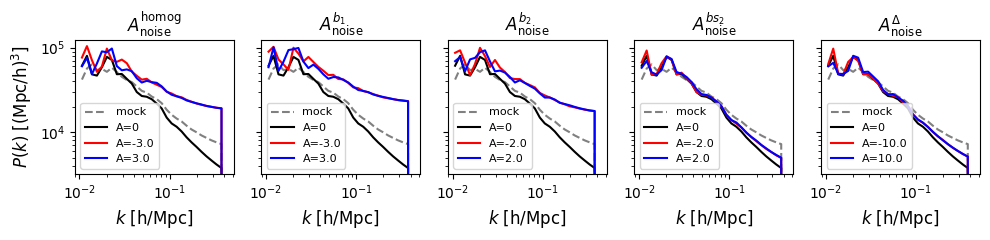

In [26]:
# Create grid plots: 2 rows x 5 columns
fig, axes = plt.subplots(1, 5, figsize=(10, 2.5), sharey=True)
axes = axes.flatten()

# Plot pk for different k-bins (top row)
for i in range(n_noiseparams):
    ax = axes[i]
    # Plot with colorbar showing P(k) value
    ax.plot(k_mock[0], y_mock[0], color='grey', ls='--', label='mock')
    ax.plot(pk_obj_noiseless['k'], pk_obj_noiseless['pk'], color='k', label=f'A=0')
    ax.plot(pk_results_arr[i][0]['k'], pk_results_arr[i][0]['pk'], c='r', label=f"A={A_noise_vals[i][0]}")
    ax.plot(pk_results_arr[i][1]['k'], pk_results_arr[i][1]['pk'], c='b', label=f"A={A_noise_vals[i][1]}")

    ax.set_xlabel(r'$k$ [h/Mpc]', fontsize=12)
    
    ax.set_title(f'{A_param_labels[i]}', fontsize=12)
    ax.set_xscale('log')
    ax.set_yscale('log')
    #cbar = plt.colorbar(ax)

    ax.legend(fontsize=8, loc='lower left')
    
axes[0].set_ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=12)
plt.tight_layout()
plt.show()

## Bispectrum

In [27]:
bspec_noiseless, bk_corr_noiseless = cs.compute_bispectrum(base, tracer_field_noiseless)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


In [28]:
# Compute bk for each parameter combination
bk_results_arr = []

n_grid_orig = 512
box_size = 1000.0
base = cs.setup_bispsec(box_size, n_grid, n_threads=1)

print(f"Computing bispectrum for {n_noiseparams} parameters, {n_Abins} values each...")
for i in range(n_noiseparams):
    bk_results_subarr = []
    for j in range(n_Abins):
        # Create parameter arrays (varying first element, others fixed)
        As_noise = A_noise_fixed.copy()
        As_noise[i] = A_noise_vals[i][j]

        # Create tracer field (following cell 95 style)
        tracer_field_noise = np.sum([As_noise[ii] * noise_field_unit * bias_terms_eul[ii] 
                                        for ii in range(len(As_noise))], axis=0) / n_grid_orig**3
        tracer_field = tracer_field_noiseless + tracer_field_noise
        
        # Compute bk
        bspec, bk_corr = cs.compute_bispectrum(base, tracer_field)
        k123 = bspec.get_ks()
        weight = k123.prod(axis=0)
        norm = n_grid**3
        bk_results_subarr.append({
            'As_noise': As_noise,
            'bk': norm**3 * weight * bk_corr['b0'],
            'k123': k123
        })
        
    bk_results_arr.append(bk_results_subarr)
    gc.collect()
    print(f"  Completed parameter {i+1}/{n_noiseparams}")


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: none
# Using fftw backend
PolyBin3D setup time: 0.18 s
Computing bispectrum for 5 parameters, 2 values each...

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
  Completed parameter 1/5

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/M

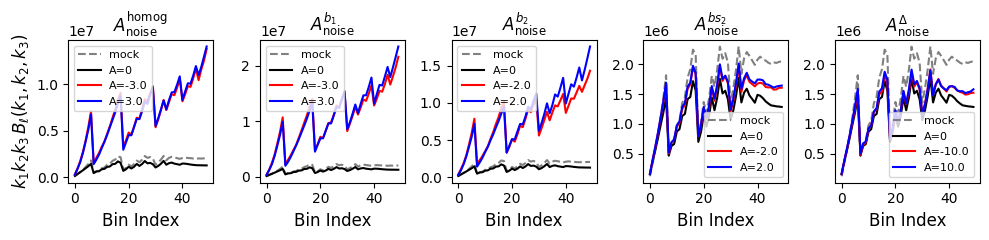

In [29]:
## Vary A_noise parameters - Plot Bispectrum

# Create grid plots: 1 row x 5 columns
fig, axes = plt.subplots(1, 5, figsize=(10, 2.5),
                         #sharey=True
                         )
axes = axes.flatten()

norm = n_grid**3
k123 = bspec_noiseless.get_ks()
weight = k123.prod(axis=0)

# Plot bk for different parameters
for i in range(n_noiseparams):
    ax = axes[i]
    # Plot noiseless first
    ax.plot(y_mock[1], color='grey', ls='--', label='mock')
    ax.plot(norm**3 * weight * bk_corr_noiseless['b0'], color='k', label=f'A=0')
    # Plot with red and blue for the two parameter values
    ax.plot(bk_results_arr[i][0]['bk'], c='r', label=f"A={A_noise_vals[i][0]}")
    ax.plot(bk_results_arr[i][1]['bk'], c='b', label=f"A={A_noise_vals[i][1]}")

    ax.set_xlabel(r'Bin Index', fontsize=12)
    ax.set_title(f'{A_param_labels[i]}', fontsize=12)
    ax.legend(fontsize=8, loc='best')
    
axes[0].set_ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$', fontsize=12)
plt.tight_layout()
plt.show()